In [0]:
!wget https://www.machinehack.com/wp-content/uploads/2020/05/Grocery_Sales_ParticipantsData.zip

--2020-05-10 17:26:21--  https://www.machinehack.com/wp-content/uploads/2020/05/Grocery_Sales_ParticipantsData.zip
Resolving www.machinehack.com (www.machinehack.com)... 107.180.71.20
Connecting to www.machinehack.com (www.machinehack.com)|107.180.71.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11478 (11K) [application/zip]
Saving to: ‘Grocery_Sales_ParticipantsData.zip’

Grocery_Sales_Parti 100%[===================>]  11.21K  --.-KB/s    in 0s      

2020-05-10 17:26:21 (77.2 MB/s) - ‘Grocery_Sales_ParticipantsData.zip’ saved [11478/11478]



In [0]:
!unzip Grocery_Sales_ParticipantsData.zip

Archive:  Grocery_Sales_ParticipantsData.zip
   creating: Grocery_Sales_ParticipantsData/
  inflating: Grocery_Sales_ParticipantsData/Test.csv  
  inflating: __MACOSX/Grocery_Sales_ParticipantsData/._Test.csv  
  inflating: Grocery_Sales_ParticipantsData/Sample_Submission.xlsx  
  inflating: __MACOSX/Grocery_Sales_ParticipantsData/._Sample_Submission.xlsx  
  inflating: Grocery_Sales_ParticipantsData/Train.csv  
  inflating: __MACOSX/Grocery_Sales_ParticipantsData/._Train.csv  


In [0]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
test = pd.read_csv('Grocery_Sales_ParticipantsData/Test.csv')
train = pd.read_csv('Grocery_Sales_ParticipantsData/Train.csv')

In [0]:
test.head(5)

,Day
0,693
1,694
2,695
3,696
4,697


In [0]:
train.head(2)

,Day,GrocerySales
0,1,8418.59
1,2,8447.47


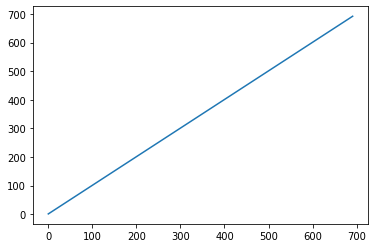

In [0]:
train['Day'].plot()

In [0]:
train_df=train

In [0]:
X = train_df.drop(labels=['GrocerySales'], axis=1)
y = train_df['GrocerySales'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=42)

In [0]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((519, 1), (519,), (173, 1), (173,))

In [0]:
from math import sqrt 
from sklearn.metrics import mean_squared_log_error

In [0]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'regression',
         'num_leaves':20,
         'boosting': 'gbdt',  
         'metric': 'mae',
         'learning_rate': 0.2, 
         'num_iterations': 1000,
         'num_leaves': 80,
         'max_depth': 6,
         'min_data_in_leaf': 11,
         'bagging_fraction': 0.80,
         'bagging_freq': 1,
         'bagging_seed': 142,
         'feature_fraction': 0.80,
         'feature_fraction_seed': 2,
         'early_stopping_round': 200,
         'max_bin': 250
         }

lgbm = lgb.train(params=param, verbose_eval=100, train_set=train_data, valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_cv)
print('RMSLE:', sqrt(mean_squared_log_error(y_cv, y_pred_lgbm)))

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's l1: 160.927
[200]	valid_0's l1: 157.512
[300]	valid_0's l1: 158.463
[400]	valid_0's l1: 160.073
[500]	valid_0's l1: 159.619
Early stopping, best iteration is:
[324]	valid_0's l1: 156.297
RMSLE: 0.025289428629484818


In [0]:
Xtest = test

In [0]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=
             20, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm = LGBMRegressor(boosting_type='dart', num_leaves=500, max_depth=31, learning_rate=0.1, n_estimators=3000, min_child_samples=20, subsample=0.80)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_log_error(y_test, y_pred_lgbm)))

    errlgb.append(sqrt(mean_squared_log_error(y_test, y_pred_lgbm)))
    p = lgbm.predict(Xtest)
    y_pred_totlgb.append(p)

RMSLE LGBM:  0.02174715163564077
RMSLE LGBM:  0.019176934845660486
RMSLE LGBM:  0.019363250757547943
RMSLE LGBM:  0.017632826919538432
RMSLE LGBM:  0.028961655210585243
RMSLE LGBM:  0.024914299189911338
RMSLE LGBM:  0.024582432969805366
RMSLE LGBM:  0.018110146229669298
RMSLE LGBM:  0.01894457853427398
RMSLE LGBM:  0.031478853636840956
RMSLE LGBM:  0.02405929131138623
RMSLE LGBM:  0.02102542295177568
RMSLE LGBM:  0.019715431909073967
RMSLE LGBM:  0.0254838676096119
RMSLE LGBM:  0.02163688945646552
RMSLE LGBM:  0.0263541599020327
RMSLE LGBM:  0.02826603321735427
RMSLE LGBM:  0.01773899564665584
RMSLE LGBM:  0.03102663445922284
RMSLE LGBM:  0.014791151952884744


In [0]:
np.mean(errlgb,0)

0.022750500417296874

In [0]:
lgbm_final = np.mean(y_pred_totlgb,0)
lgbm_final

array([8886.31348043, 8886.31348043, 8886.31348043, 8886.31348043,
       8886.31348043, 8886.31348043, 8886.31348043, 8886.31348043,
       8886.31348043, 8886.31348043, 8886.31348043, 8886.31348043,
       8886.31348043, 8886.31348043, 8886.31348043, 8886.31348043,
       8886.31348043, 8886.31348043, 8886.31348043, 8886.31348043,
       8886.31348043, 8886.31348043, 8886.31348043, 8886.31348043,
       8886.31348043, 8886.31348043, 8886.31348043, 8886.31348043,
       8886.31348043, 8886.31348043, 8886.31348043, 8886.31348043,
       8886.31348043, 8886.31348043, 8886.31348043, 8886.31348043,
       8886.31348043, 8886.31348043, 8886.31348043, 8886.31348043,
       8886.31348043, 8886.31348043, 8886.31348043, 8886.31348043,
       8886.31348043, 8886.31348043, 8886.31348043, 8886.31348043,
       8886.31348043, 8886.31348043, 8886.31348043, 8886.31348043,
       8886.31348043, 8886.31348043, 8886.31348043, 8886.31348043,
       8886.31348043, 8886.31348043, 8886.31348043, 8886.31348

In [0]:
submission = pd.DataFrame({
        "Day": test['Day'],
        "GrocerySales": lgbm_final
    })
submission.to_csv('./Av1.csv', index=False)
print(submission)

    Day  GrocerySales
0   693    8886.31348
1   694    8886.31348
2   695    8886.31348
3   696    8886.31348
4   697    8886.31348
..  ...           ...
85  778    8886.31348
86  779    8886.31348
87  780    8886.31348
88  781    8886.31348
89  782    8886.31348

[90 rows x 2 columns]


In [0]:
from google.colab import files
files.download('Av1.csv')

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(verbose=1, learning_rate=0.1, n_estimators=100, random_state=101, subsample=0.8, loss='ls')
gb.fit(X_train, y_train)
y_pred = gb.predict(X_cv)
print('score', (sqrt(mean_squared_log_error(y_cv, y_pred))))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      164163.0027       17573.1605            0.14s
         2      146835.5231       14222.6048            0.14s
         3      139038.2054       11648.9032            0.14s
         4      130719.5448        9930.8493            0.13s
         5      124649.9671        7127.7634            0.12s
         6      116305.9061        6917.7535            0.11s
         7      109250.0473        3578.4409            0.11s
         8      115069.2614        2569.5992            0.11s
         9       96107.0432        4202.1105            0.11s
        10       92954.2594        6251.5206            0.10s
        20       61603.0461         905.0582            0.06s
        30       41133.9178         150.1872            0.05s
        40       31914.0256         167.9254            0.04s
        50       26415.7283         570.2208            0.03s
        60       21715.2856         288.2691            0.02s
       

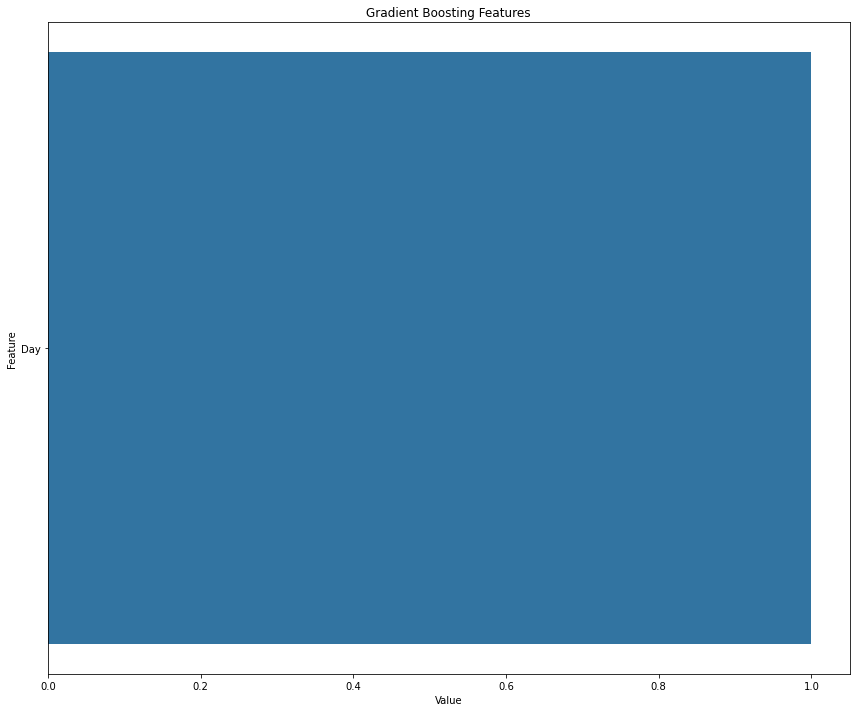

In [0]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(gb.feature_importances_, X.columns), reverse=True)[:60], columns=['Value','Feature'])
plt.figure(figsize=(12,10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Gradient Boosting Features')
plt.tight_layout()
plt.show()

In [0]:
Xtest = test

In [0]:
from sklearn.model_selection import KFold

errgb = []
y_pred_totgb = []

fold = KFold(n_splits=20, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
             
    gb = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, random_state=101, subsample=0.8, loss='ls')
    #gb = GradientBoostingRegressor(learning_rate=0.01, n_estimators=100, random_state=101, subsample=0.8,loss='ls')
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    print('Score', sqrt(mean_squared_log_error(y_test, y_pred)))

    errgb.append(sqrt(mean_squared_log_error(y_test, y_pred)))
    p = gb.predict(Xtest)
    y_pred_totgb.append(p)

Score 0.023123714307205702
Score 0.02038752265652427
Score 0.021134723304345748
Score 0.01709906733156022
Score 0.02960183279947127
Score 0.01675828584012277
Score 0.02291166333973819
Score 0.01742779879500539
Score 0.015426523327092604
Score 0.028269989207458802
Score 0.020636013556564144
Score 0.022052489918392964
Score 0.024055043955125303
Score 0.01975552915972898
Score 0.023167075730254123
Score 0.020192676392916185
Score 0.025344844701909768
Score 0.01831704493871138
Score 0.028851724421055002
Score 0.015282578562838992


In [0]:
np.mean(errgb,0)

0.02148980711230109

In [0]:
cat_final = np.mean(y_pred_totgb,0)
cat_final

array([9008.61258212, 9008.61258212, 9008.61258212, 9008.61258212,
       9008.61258212, 9008.61258212, 9008.61258212, 9008.61258212,
       9008.61258212, 9008.61258212, 9008.61258212, 9008.61258212,
       9008.61258212, 9008.61258212, 9008.61258212, 9008.61258212,
       9008.61258212, 9008.61258212, 9008.61258212, 9008.61258212,
       9008.61258212, 9008.61258212, 9008.61258212, 9008.61258212,
       9008.61258212, 9008.61258212, 9008.61258212, 9008.61258212,
       9008.61258212, 9008.61258212, 9008.61258212, 9008.61258212,
       9008.61258212, 9008.61258212, 9008.61258212, 9008.61258212,
       9008.61258212, 9008.61258212, 9008.61258212, 9008.61258212,
       9008.61258212, 9008.61258212, 9008.61258212, 9008.61258212,
       9008.61258212, 9008.61258212, 9008.61258212, 9008.61258212,
       9008.61258212, 9008.61258212, 9008.61258212, 9008.61258212,
       9008.61258212, 9008.61258212, 9008.61258212, 9008.61258212,
       9008.61258212, 9008.61258212, 9008.61258212, 9008.61258

In [0]:
submission = pd.DataFrame({
        "Day": test['Day'],
        "GrocerySales": cat_final
    })
submission.to_csv('./Av1.csv', index=False)
print(submission)

    Day  GrocerySales
0   693   9008.612582
1   694   9008.612582
2   695   9008.612582
3   696   9008.612582
4   697   9008.612582
..  ...           ...
85  778   9008.612582
86  779   9008.612582
87  780   9008.612582
88  781   9008.612582
89  782   9008.612582

[90 rows x 2 columns]


In [0]:
from google.colab import files
files.download('Av1.csv')